# A Population-Based Metaheuristic for Fast Camouflaged Adversarial Patch Generation

## Project Goal

This project explores an alternative method for creating camouflaged adversarial patches, as introduced by Williams & Li. The original paper used an Evolutionary Strategy with Simulated Annealing to generate these patches, which are made of semi-transparent circles designed to fool image recognition systems while being hard to see. While the computational art framework is innovative and effective, the method may be limited by the use of a single-trajactory search strategy, particularly when trying to simultaneously optimize patch content and placement.

This notebook implements and tests a custom PSO implementation with a similar computational art inspiration. The aim is to see if PSO can find effective, low-visibility patches more efficiently than the methods used in the original paper and other standard techniques.


## How to Use This Notebook

1.  **Environment:** This notebook was designed to be portable, and runs in most notebook environments. A GPU runtime is strongly recommended for faster model inference, but a CPU will work.

2.  **Libraries:** The code uses de facto standard Python libraries readily available in Google Colab. No extra installations are needed. Test images are pulled from an online sample repository by default for portability, but local images can easily be used so long as they are uploaded to session storage.

3.  **Running the Cells:** Execute the cells in order from top to bottom.
    * **Cell 1:** Imports required libraries.
    * **Cells 2-7:** Define necessary functions and classes for patch generation, evaluation, PSO, and plotting.
    * **Cell 8:** Defines the main `run()` function to execute the PSO algorithm.
    * **Cell 9:** Sets parameters and runs the main PSO experiment. This is the core experiment.
    * **Appendix A (Optional):** Runs a sensitivity analysis for selected PSO hyperparameters.
    * **Appendix B (Optional):** Runs a Random Search baseline for comparison.
    * **Appendix C (Optional):** Runs a Stochastic Hill Climbing baseline for comparison.
    * **Appendix D (Optional):** Generates the averaged convergence plot (Figure 2 in the report) using saved data from multiple runs.
    * **Appendix E (Optional):** Generates patch placement comparison plots (Figure 5 in the report).
    * **Appendix F (Optional):** Calculates statistics, performs tests, and generates the summary results table (Table 1 in the report).

4.  **Reproducibility:** The notebook is designed for reproducibility. Running Cell 9 executes the main PSO experiment. Appendices A-F run the other analyses and comparisons independently. Clear instructions are provided throughout.

5.  **Outputs:** Each experiment run will:
    * Print progress updates.
    * Show a summary of the best patch found.
    * Display a figure comparing the original image, the best patch, and the modified image.
    * Show a plot illustrating how the solution improved over time (convergence plot).

In [ ]:
# Imports

# For core algorithm
import numpy as np
from PIL import Image, ImageDraw
import io
import matplotlib.pyplot as plt
import time
import random
import os

# Only used if fetching test images from the online repository
import requests

# For the target model and fitness evaluation
import torch
import torchvision
import torchvision.transforms as T
from torchvision.models import ResNet50_Weights

## Cell 2 - Image Helper Functions
Run once to define the functions for later use

In [ ]:
def preprocess_image(image_source: str, target_size: int = 224) -> tuple[Image.Image, Image.Image, torch.Tensor]:
    """
    Loads an image from a URL or local path, performs basic pre-processing,
    and prepares it as a PyTorch tensor.

    Args:
        image_source (str): The URL or local file path of the image.
        target_size (int): The desired square size for the final cropped image (default: 224).

    Returns:
        A tuple containing:
        - original_pil (Image.Image): The original loaded image.
        - cropped_pil (Image.Image): The resized and center-cropped image.
        - cropped_tensor_unnorm (torch.Tensor): The cropped image as an unnormalised
          PyTorch tensor [B, C, H, W] on DEVICE.
    """
    # Load image
    if image_source.startswith(("http://", "https://")):
        # Load from URL
        headers = {"User-Agent": "Mozilla/5.0"}
        response = requests.get(image_source, headers=headers, timeout=15)
        response.raise_for_status()
        img_bytes = io.BytesIO(response.content)
        original_full_pil = Image.open(img_bytes)
    else:
        # Load from local path
        original_full_pil = Image.open(image_source)

    # Ensure image is in RGB format after loading
    original_full_pil = original_full_pil.convert("RGB")

    # Define transforms
    preprocess_pil = T.Compose([
        T.Resize(256, interpolation=T.InterpolationMode.BICUBIC),
        T.CenterCrop(target_size)
    ])
    preprocess_tensor = T.ToTensor()

    # Apply transforms
    cropped_pil_image = preprocess_pil(original_full_pil)
    img_tensor_unnormalised = preprocess_tensor(cropped_pil_image).unsqueeze(0).to(DEVICE)

    return original_full_pil, cropped_pil_image, img_tensor_unnormalised

def normalise_tensor(img_tensor: torch.Tensor) -> torch.Tensor:
    """
    Normalises a tensor using predefined imageNet mean and standard deviation.

    Args:
        img_tensor: The input tensor [B, C, H, W].

    Returns:
        The normalised tensor.
    """
    return (img_tensor - IMAGENET_MEAN) / IMAGENET_STD


def denormalise_tensor(img_tensor: torch.Tensor) -> torch.Tensor:
    """
    Reverses ImageNet normalisation for visualisation later on.

    Args:
        img_tensor: The normalised input tensor.

    Returns:
        The denormalised tensor, clamped to the valid [0, 1] range.
    """
    # Apply the inverse operations
    img = img_tensor * IMAGENET_STD + IMAGENET_MEAN
    return torch.clamp(img, 0, 1)

## Cell 3 - Image Palette Generation Functions
Run once to define the functions for later use

In [ ]:
def calculate_distance_sq_np(point1: np.ndarray, point2: np.ndarray) -> float:
    """
    Calculates squared Euclidean distance between two points (avoids sqrt).
    """
    return np.sum((point1 - point2)**2)

def extract_palette_manual_kmeans(pil_image: Image.Image, n_colors: int = 16, max_iters: int = 100, tol: float = 1.0) -> torch.Tensor | None:
    """
    Extracts K colors from a PIL image via a manual numpy-based K-Means implementation.
    (I'm wary of doing anything via an external library for the assignment)
    ((Could easily be swapped out with sklearn))

    Args:
        pil_image: Input PIL Image.
        n_colors: Desired number of colors (K).
        max_iters: Maximum iterations.
        tol: Convergence tolerance based on squared centroid shift.

    Returns:
        torch.Tensor [K, 3] (CPU, scaled 0-1) representing the color palette,
        or None if extraction fails.
    """
    # Convert PIL image to NumPy array [H, W, 3]
    img_array = np.array(pil_image)

    # Reshape image into a flat list of pixels [N, 3]
    pixels = img_array.reshape(-1, 3).astype(np.float32)
    n_pixels = pixels.shape[0]

    # Adjust K if the image has fewer unique pixels than requested colors
    actual_n_colors = min(n_colors, n_pixels)

    # Randomly select K unique pixels as initial centroids
    indices = np.random.choice(n_pixels, actual_n_colors, replace=False)
    centroids = pixels[indices].copy()

    # Main K-Means iteration loop
    for i in range(max_iters):
        # Calculate squared distances between all pixels and all centroids
        # distances_sq shape: [n_pixels, actual_n_colors]
        distances_sq = np.sum((pixels[:, np.newaxis, :] - centroids[np.newaxis, :, :])**2, axis=2)
        # Find the index of the minimum distance for each pixel
        cluster_assignments = np.argmin(distances_sq, axis=1) # shape: [n_pixels]

        # Recalculate centroids as the mean of assigned pixels
        new_centroids = np.zeros((actual_n_colors, 3), dtype=np.float32)
        counts = np.zeros(actual_n_colors, dtype=int)

        # np.add.at for vectorised accumulation of values and counts
        np.add.at(new_centroids, cluster_assignments, pixels)
        np.add.at(counts, cluster_assignments, 1)

        # Handle potential empty clusters
        valid_clusters = counts > 0
        # Avoid division by zero
        new_centroids[valid_clusters] = new_centroids[valid_clusters] / counts[valid_clusters][:, np.newaxis]

        # For empty clusters, revert to previous centroid position
        empty_clusters = ~valid_clusters
        if np.any(empty_clusters):
            new_centroids[empty_clusters] = centroids[empty_clusters]

        # Calculate the total squared distance between old and new centroids
        centroid_shift_sq = np.sum((new_centroids - centroids)**2)
        centroids = new_centroids

        # Compare shift against squared tolerance (avoids sqrt)
        if centroid_shift_sq < tol**2:
            print(f"K-Means converged after {i+1} iterations.")
            break

    # Ensure final centroids are valid RGB values
    palette_rgb_255 = np.clip(centroids, 0, 255).astype(np.uint8)
    # Scale palette to 0.0-1.0 range
    palette_rgb_01 = palette_rgb_255 / 255.0
    # Convert to pytorch tensor on CPU
    palette_tensor_01_cpu = torch.tensor(palette_rgb_01, dtype=torch.float32, device="cpu")

    return palette_tensor_01_cpu

def find_closest_palette_colors_vectorised(current_colors: torch.Tensor,
                                           palette_cpu: torch.Tensor | None) -> torch.Tensor:
    """
    Finds the closest palette color for each input color using torch.cdist.

    Args:
        current_colors: Tensor of shape (N, 3) with colors to map.
        palette_cpu: Tensor of shape (P, 3) with palette colors (on CPU).

    Returns:
        Tensor of shape (N, 3) with input colors replaced by their nearest palette match.
        Returns original 'current_colors' if palette is invalid or on error.
    """
    # Edge cases
    if palette_cpu is None or palette_cpu.nelement() == 0 or current_colors.nelement() == 0:
        return current_colors

    # Ensure palette is on the same device as the colors being checked
    device = current_colors.device
    palette_on_device = palette_cpu.to(device)

    # Calculate all pairwise squared Euclidean distances efficiently
    # cdist shape: (N, P)
    distances_sq = torch.cdist(current_colors, palette_on_device, p=2.0).pow(2)
    # Find the index of the closest palette color for each input color
    min_indices = torch.argmin(distances_sq, dim=1) # Shape: (N)
    # Select the corresponding colors from the palette
    closest_colors = palette_on_device[min_indices] # Shape: (N, 3)

    return closest_colors

def visualise_palette(palette_tensor_01_cpu: torch.Tensor | None):
    """
    Displays the extracted color palette using Matplotlib.
    """

    # Convert tensor to numpy array
    palette_np_01 = palette_tensor_01_cpu.cpu().numpy() # Shape: [K, 3]

    # Reshape palette to [1, K, 3] for imshow
    palette_vis = np.expand_dims(palette_np_01, axis=0)

    # Plotting
    plt.figure(figsize=(10, 2))
    plt.imshow(palette_vis, aspect="auto")
    plt.title(f"Extracted Color Palette ({palette_np_01.shape[0]} Colors)")
    plt.axis("off")
    plt.show()


# Test uage
#     _ , test_img_pil_cropped, _ = preprocess_image(IMAGE_URL, IMG_SIZE)
#     print(f"Test image loaded and cropped to {test_img_pil_cropped.size}.")
#     test_palette = extract_palette_manual_kmeans(test_img_pil_cropped, PALETTE_SIZE)
#     if test_palette is not None:
#         visualise_palette(test_palette)
#     else:
#         print("Palette extraction failed for the test image.")
# image_palette_01 = None

## Cell 4 - Patch Generation and Application Functions
Run once to define the functions for later use

In [ ]:
def generate_patch(particle_params: torch.Tensor | np.ndarray,
                               patch_size: int = 40,
                               num_circles: int = 100) -> Image.Image:
    """
    Generates RGBA PIL patch by alpha compositing circles from parameters.
    """
    # Work with numpy array on CPU
    if isinstance(particle_params, torch.Tensor):
        p_params_cpu = particle_params.detach().cpu().numpy()
    else:
        p_params_cpu = np.asarray(particle_params)

    # Extract circle parameters
    circle_params_all = p_params_cpu[2:]

    # Start with a fully transparent base layer
    patch_img = Image.new("RGBA", (patch_size, patch_size), (0, 0, 0, 0))

    # Iterate through circles and composite them
    # Compositing ensures the patch can properly blend with the input image
    for i in range(num_circles):
        start_idx = i * 7 # 7 params per circle
        params = circle_params_all[start_idx : start_idx + 7]

        # Parse parameters for the current circle
        cx_norm, cy_norm, r_norm, r_val, g_val, b_val, alpha_val = map(float, params)

        # Denormalise parameters to pixel coordinates and color values
        cx, cy = cx_norm * patch_size, cy_norm * patch_size
        # Ensure minimum radius of 1 pixel
        radius = max(1.0, r_norm * patch_size * 0.5)
        # Clamp color/alpha values to valid 0-255 range
        color_rgba = tuple(int(np.clip(v * 255, 0, 255)) for v in [r_val, g_val, b_val, alpha_val])

        # Draw each circle on its own layer for alpha compositing
        circle_layer = Image.new("RGBA", (patch_size, patch_size), (0, 0, 0, 0))
        draw_circle = ImageDraw.Draw(circle_layer)
        # Calculate integer bounding box coordinates for PIL ellipse
        x1, y1 = int(cx - radius + 0.5), int(cy - radius + 0.5)
        x2, y2 = int(cx + radius + 0.5), int(cy + radius + 0.5)

        draw_circle.ellipse([x1, y1, x2, y2], fill=color_rgba)

        # Composite the current circle layer onto the main patch image
        patch_img = Image.alpha_composite(patch_img, circle_layer)

    return patch_img

def generate_patch_tensors(patch_pil_image: Image.Image) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Converts RGBA PIL patch to RGB & Alpha tensors ([0,1], on DEVICE).
    """
    # Ensure image is RGBA for splitting
    if patch_pil_image.mode != "RGBA":
        patch_pil_image = patch_pil_image.convert("RGBA")

    # Convert PIL to Tensor and move to target device
    patch_tensor = T.ToTensor()(patch_pil_image).to(DEVICE) # Shape: [4, H, W]

    # Separate RGB and alpha channels
    patch_rgb = patch_tensor[:3, :, :] # Shape: [3, H, W]
    patch_alpha = patch_tensor[3:4, :, :] # Shape: [1, H, W]
    return patch_rgb, patch_alpha

def apply_patch(image_tensor_unnormalised: torch.Tensor,
                patch_rgb: torch.Tensor,
                patch_alpha: torch.Tensor,
                particle_params: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Applies patch tensors to an image tensor via alpha blending.

    Args:
        image_tensor_unnormalised: Target image (B=1, C, H, W), scale [0, 1].
        patch_rgb: Patch RGB tensor (C=3, pH, pW), scale [0, 1].
        patch_alpha: Patch Alpha tensor (C=1, pH, pW), scale [0, 1].
        particle_params: Tensor containing patch location parameters.

    Returns:
        Tuple of (patched_image_tensor, original_background_area_tensor).
    """
    img_h, img_w = image_tensor_unnormalised.shape[2], image_tensor_unnormalised.shape[3]
    patch_h, patch_w = patch_rgb.shape[1], patch_rgb.shape[2]

    # Extract location parameters
    loc_params = particle_params[:2]

    # Calculate patch top-left coordinates
    patch_x = torch.clamp(loc_params[0].round(), 0, img_w - patch_w).int()
    patch_y = torch.clamp(loc_params[1].round(), 0, img_h - patch_h).int()

    # Avoid modifying the original tensor
    patched_image = image_tensor_unnormalised.clone()
    # Extract the original image area that will be covered by the patch
    # Shape: [C, pH, pW]
    original_background_area = image_tensor_unnormalised[0, :, patch_y:patch_y + patch_h, patch_x:patch_x + patch_w]

    # Perform alpha blending
    # = background * (1 - alpha) + patch * alpha
    blended_area = original_background_area * (1.0 - patch_alpha) + patch_rgb * patch_alpha

    # Place the blended area back into the image
    patched_image[0, :, patch_y:patch_y + patch_h, patch_x:patch_x + patch_w] = blended_area

    return patched_image, original_background_area

## Cell 5 - Fitness Evaluation Function
Run once to define the function for later use

In [ ]:
def evaluate_fitness(particle_params: torch.Tensor,
                     original_image_tensor_unnormalised: torch.Tensor,
                     original_label: int,
                     target_model: torch.nn.Module,
                     patch_size: int = 40,
                     num_circles: int = 100,
                     tolerance: float = 0.5) -> tuple[float, bool, float, torch.Tensor]:
    """
    Evaluates particle fitness based on model prediction margin and L2 distance.

    Fitness is the L2 distance between the patch and original background if
    the attack margin (original_logit - highest_other_logit) is below tolerance,
    otherwise fitness is infinity. Lower fitness is better.

    Args:
        particle_params: Tensor defining the patch location and circle parameters.
        original_image_tensor_unnormalised: Base image tensor [1, C, H, W], scale [0, 1].
        original_label: The true label index for the original image.
        target_model: The torch model to evaluate against.
        patch_size: The dimension of the square patch.
        num_circles: The number of circles composing the patch.
        tolerance: The required margin reduction for the attack to be considered.

    Returns:
        Tuple: (fitness, is_misclassified, l2_dist, patched_img_unnorm)
            - fitness (float): L2 dist if margin < tolerance, else inf.
            - is_misclassified (bool): True if top prediction is not original_label.
            - l2_dist (float): L2 distance between patch RGB and original background.
            - patched_img_unnorm (torch.Tensor): The image tensor with patch applied.
    """
    # Create the patch PIL image from circle parameters
    patch_pil = generate_patch(particle_params, patch_size, num_circles)
    # Convert PIL patch to RGB and alpha tensors on the correct device
    patch_rgb, patch_alpha = generate_patch_tensors(patch_pil)
    # Apply the patch tensors onto the original image tensor
    patched_image_unnormalised, background_area = apply_patch(
        original_image_tensor_unnormalised, patch_rgb, patch_alpha, particle_params
    )

    # Normalise image for model input
    patched_image_normalised = normalise_tensor(patched_image_unnormalised)
    # Perform inference
    with torch.no_grad():
        target_model.eval()
        outputs = target_model(patched_image_normalised).detach() # Shape: [1, num_classes]

    logits = outputs[0] # Get logits for the single image in the batch
    # Sort logits to find top predictions
    sorted_logits, sorted_indices = torch.sort(logits, descending=True)

    # Margin = Z_t - max_{i!=t}(Z_i), where Z_t is the logit for the original class
    original_logit = logits[original_label]
    # Find the highest logit not corresponding to the original label
    if sorted_indices[0].item() == original_label:
        # Original label is still the top prediction
        highest_other_logit = sorted_logits[1] if len(sorted_logits) > 1 else original_logit - 1e-6
    else:
        # A different label is now the top prediction (yay!)
        highest_other_logit = sorted_logits[0]

    margin = original_logit - highest_other_logit

    # Used to update pbest
    meets_tolerance = margin.item() < tolerance

    # Used to update gbest
    truly_misclassified = (sorted_indices[0].item() != original_label)

    #l2_distance = torch.linalg.norm(patch_rgb - background_area).item()
    l2_distance = torch.sum((patch_rgb - background_area).pow(2)).item() # matches CamoPatch

    # Fitness prioritises meeting the margin tolerance (meets_tolerance)
    # Only if the margin is met, the L2 distance is used as the fitness value
    fitness = l2_distance if meets_tolerance else float("inf")

    return fitness, truly_misclassified, l2_distance, patched_image_unnormalised

## Cell 6 - PSO Class
Run once to define the class for later use

In [ ]:
class Particle:
    """
    Represents a single particle in the PSO swarm.
    """

    def __init__(self, dim: int, bounds_min: torch.Tensor, bounds_max: torch.Tensor, device: torch.device):
        """
        Initialises particles' position, velocity, bounds, and fitness.
        """
        self.dim = dim
        self.bounds_min = bounds_min.to(device)
        self.bounds_max = bounds_max.to(device)
        self.device = device
        param_range = self.bounds_max - self.bounds_min

        # Initialise position randomly within bounds
        self.position = torch.rand(dim, device=self.device) * param_range + self.bounds_min
        # Initialise velocity randomly, scaled by parameter range
        self.velocity = torch.randn(dim, device=self.device) * 0.1 * param_range

        # Personal best tracking
        self.best_position = self.position.clone()
        self.best_fitness = float("inf")

        # Current state tracking
        self.fitness = float("inf")
        self.l2_distance = float("inf")
        self.truly_misclassified = False # For gbest

    def update_velocity(self, gbest_pos: torch.Tensor,
                        palette_cpu: torch.Tensor | None,
                        w: float, c1: float, c2: float, g: float,
                        circle_indices_rgb: tuple[np.ndarray, np.ndarray, np.ndarray]):
        """
        Updates particle velocity.
        """
        gbest_pos = gbest_pos.to(self.device)
        # Random components for cognitive and social terms
        r1 = torch.rand(self.dim, device=self.device)
        r2 = torch.rand(self.dim, device=self.device)

        # Inertia: tendency to continue in the same direction
        inertia_term = w * self.velocity
        # Cognitive: attraction towards pbest
        cognitive_vel = c1 * r1 * (self.best_position - self.position)
        # Social: attraction towards gbest
        social_vel = c2 * r2 * (gbest_pos - self.position)

        # Pull circle colors towards the nearest colors in the palette
        gravity_adj = torch.zeros_like(self.velocity)
        num_circles = len(circle_indices_rgb[0]) if circle_indices_rgb else 0

        # Apply gravity only if weight > 0 and palette exists
        if g > 0 and palette_cpu is not None and palette_cpu.nelement() > 0:
            # Get indices for R, G, B components of all circles within the flat position vector
            idx_r = torch.tensor(circle_indices_rgb[0], device=self.device, dtype=torch.long)
            idx_g = torch.tensor(circle_indices_rgb[1], device=self.device, dtype=torch.long)
            idx_b = torch.tensor(circle_indices_rgb[2], device=self.device, dtype=torch.long)

            # Extract current circle colors [num_circles, 3]
            current_colors = torch.stack([self.position[idx_r], self.position[idx_g], self.position[idx_b]], dim=1)
            # Find the nearest palette colors for these current colors
            closest_colors = find_closest_palette_colors_vectorised(current_colors, palette_cpu)
            # Calculate the pull direction
            gravity_pull = g * (closest_colors - current_colors) # Shape: [num_circles, 3]

            # Apply the gravity pull
            gravity_adj.scatter_add_(0, idx_r, gravity_pull[:, 0])
            gravity_adj.scatter_add_(0, idx_g, gravity_pull[:, 1])
            gravity_adj.scatter_add_(0, idx_b, gravity_pull[:, 2])
            # Using scatter_add_ ensures correct handling if multiple circles share parameters (unlikely but safe)

        # Experimenting with randomness
        #if np.random.uniform() > 0.95:
        #    random_term = torch.randn_like(self.velocity) * 0.1
        #else:
        #    random_term = torch.zeros_like(self.velocity)
        #self.velocity = inertia_term + cognitive_vel + social_vel + gravity_adj + random_term

        # Combine velocity components
        self.velocity = inertia_term + cognitive_vel + social_vel + gravity_adj

    def update_position(self):
        """
        Updates particle position based on velocity and clamps to bounds.
        """
        self.position += self.velocity
        self.position = torch.clamp(self.position, self.bounds_min, self.bounds_max)

        # Reinitialisation
        #if np.random.uniform() > 1.0 / 100:
        #    rand_tensor = torch.rand_like(self.position)
        #    self.position = rand_tensor * (self.bounds_max - self.bounds_min) + self.bounds_min

    def evaluate(self, img_unnorm: torch.Tensor, label: int, model: torch.nn.Module,
                 patch_sz: int, num_circ: int, tol: float):
        """
        Evaluates particle's current position using the external fitness function.
        Updates the particle's current fitness/state and its personal best.
        """
        # Call the main fitness evaluation function
        fitness, is_misclassified, l2, _ = evaluate_fitness(
            self.position, img_unnorm, label, model, patch_sz, num_circ, tol
        )

        # Store results for the current position
        self.fitness = fitness
        self.truly_misclassified = is_misclassified
        self.l2_distance = l2

        # Update pbest if current fitness is better
        if self.fitness < self.best_fitness:
            self.best_fitness = self.fitness
            self.best_position = self.position.clone()

## Cell 7 - Plotting Functions
Run once to define the functions for later use

In [ ]:
def plot_results_figure(original_pil: Image.Image,
                        patch_viz_pil: Image.Image,
                        adversarial_pil: Image.Image,
                        original_label_str: str,
                        final_predicted_label_str: str,
                        best_l2: float,
                        title_suffix: str = ""):
    """
    Displays a 1x3 plot: Original image, patch visualisation, adversarial image.
    """
    plt.figure(figsize=(18, 6))
    title_prefix = f"{title_suffix} " if title_suffix else ""

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(original_pil)
    plt.title(f"Original Image\n(Pred: {original_label_str})")
    plt.axis("off")

    # Patch visualisation
    plt.subplot(1, 3, 2)
    plt.imshow(patch_viz_pil)
    # Format L2 distance, handling infinity if no successful patch was found
    l2_str = f"{best_l2:.4f}" if best_l2 != float("inf") else "N/A"
    plt.title(f"{title_prefix}Best Patch (L2: {l2_str})\n(Viz on gray background)")
    plt.axis("off")

    # Adversarial image
    plt.subplot(1, 3, 3)
    plt.imshow(adversarial_pil)
    plt.title(f"{title_prefix}Adversarial Image\n(Pred: {final_predicted_label_str})")
    plt.axis("off")

    plt.suptitle(f"{title_prefix}Attack Results", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


def plot_convergence(query_history: list[int], best_l2_history: list[float], algorithm_name: str = ""):
    """
    Plots the best L2 distance found vs. number of model queries.
    """
    plt.figure(figsize=(10, 6))
    title_prefix = f"{algorithm_name} " if algorithm_name else ""

    # We want to plot the L2 distance when it improves or stays the same.
    # Skip points where L2 is still infinite unless it's a plateau extending from a valid L2.
    plot_queries = []
    plot_l2 = []
    last_valid_l2 = float("inf") # Track the last non-infinite L2 found

    for q, l2 in zip(query_history, best_l2_history):
        # Skip the initial state before any queries
        if q == 0: continue

        if l2 != float("inf"):
            # Found a successful patch, record it
            plot_queries.append(q)
            plot_l2.append(l2)
            last_valid_l2 = l2
        elif last_valid_l2 != float("inf"):
            # Current L2 is inf, but we previously found a successful patch.
            # Extend the plot horizontally at the last valid L2 value.
            if not plot_queries or q > plot_queries[-1]:
                 plot_queries.append(q)
                 plot_l2.append(last_valid_l2)

    # Plotting
    if plot_queries:
        # Only plot if at least one successful patch was found
        plt.plot(plot_queries, plot_l2, marker='.', linestyle='-')
        plt.xlabel("Model Queries (Fitness Evaluations)")
        plt.ylabel("Best Successful L2 Distance Found")
        plt.title(f"{title_prefix}Optimisation Progress: Best L2 vs. Queries")
        plt.grid(True)

        min_l2_val = min(plot_l2)
        max_l2_val = max(plot_l2)
        # Add a small margin
        y_margin = (max_l2_val - min_l2_val) * 0.05 if max_l2_val > min_l2_val else 0.1
        # Ensure bottom limit is not negative for L2 distance
        y_bottom = max(0, min_l2_val - y_margin)
        y_top = max_l2_val + y_margin

        # Apply limits only if they form a valid range
        if y_bottom < y_top:
              plt.ylim(bottom=y_bottom, top=y_top)

        plt.tight_layout()
        plt.show()
    else:
        # Handle the case where no successful attack was ever found during the run
        print(f"Convergence plot skipped for {algorithm_name}: No successful patch found.")

# Cell 8 - Core Optimisation Function
Run once to define the function for later use

In [ ]:
def run(image_url: str,
        target_model_factory,
        target_model_weights,
        img_size: int,
        palette_size: int,
        patch_size: int,
        num_circles: int,
        pso_population_size: int,
        pso_generations: int,
        pso_w: float,
        pso_c1: float,
        pso_c2: float,
        constraint_tolerance: float,
        gravity_factor: float,
        device: torch.device,
        plot=True):
    """
    Runs the PSO-based adversarial patch generation process.
    """
    main_start_time = time.time()

    # Instantiate the target model
    target_model = target_model_factory(weights=target_model_weights)
    target_model.eval().to(device)

    # Load and preprocess the input image
    original_full_pil, cropped_pil_image, original_tensor_unnormalised = preprocess_image(image_url, img_size)
    original_tensor_normalised = normalise_tensor(original_tensor_unnormalised)

    # Get the model's prediction on the original image
    with torch.no_grad():
        original_outputs = target_model(original_tensor_normalised)
    original_probs = torch.softmax(original_outputs, dim=1)
    original_label_idx = torch.argmax(original_probs, dim=1).item()
    original_confidence = original_probs[0, original_label_idx].item()

    # Retrieve the label names from the model weights metadata
    imagenet_labels = target_model_weights.meta["categories"]
    original_label_str = imagenet_labels[original_label_idx]

    print(f"\nOriginal prediction: {original_label_str} ({original_label_idx}) at {original_confidence:.4f} conf.")

    # If gravity is applied, extract a color palette from the cropped image using k-means
    image_palette_01_cpu = None
    if gravity_factor > 0:
        image_palette_01_cpu = extract_palette_manual_kmeans(cropped_pil_image, palette_size)
        if image_palette_01_cpu is None:
            gravity_factor = 0

    # Calculate the dimension of the search particle
    n_params_per_circle = 7
    n_patch_loc_params = 2
    particle_dim = n_patch_loc_params + num_circles * n_params_per_circle

    # Compute indices for the RGB color parameters of each circle within the particle
    circle_indices_rgb = (
        np.arange(num_circles) * n_params_per_circle + n_patch_loc_params + 3,
        np.arange(num_circles) * n_params_per_circle + n_patch_loc_params + 4,
        np.arange(num_circles) * n_params_per_circle + n_patch_loc_params + 5
    )

    # Define the allowed bounds for patch location parameters
    loc_bounds = [(0, img_size - patch_size)] * n_patch_loc_params
    circle_bounds_spec = [(0, 1)] * n_params_per_circle
    circle_bounds_spec[2], circle_bounds_spec[6] = (0.01, 0.5), (0.05, 1.0) # r_norm, alpha

    # Create a complete list of circle bounds
    all_circle_bounds_list = []
    for _ in range(num_circles): all_circle_bounds_list.extend(circle_bounds_spec)
    param_bounds_min_np = np.array([b[0] for b in loc_bounds] + [b[0] for b in all_circle_bounds_list], dtype=np.float32)
    param_bounds_max_np = np.array([b[1] for b in loc_bounds] + [b[1] for b in all_circle_bounds_list], dtype=np.float32)
    param_bounds_min = torch.tensor(param_bounds_min_np, dtype=torch.float32, device=device)
    param_bounds_max = torch.tensor(param_bounds_max_np, dtype=torch.float32, device=device)

    # PSO initialisation
    particles = [Particle(particle_dim, param_bounds_min, param_bounds_max, device)
                 for _ in range(pso_population_size)]
    global_best_l2 = float("inf")
    global_best_position = torch.zeros(particle_dim, device=device)
    found_successful_patch = False
    successful_patch_details = {}
    total_queries = 0
    query_history = [0]
    best_l2_history = [float("inf")]

    print(f"PSO init: pop={pso_population_size}, gens={pso_generations}, target='{original_label_str}'")

    # PSO Optimisation Loop
    start_time = time.time()
    for generation in range(pso_generations):
        successful_in_gen = 0
        gen_l2_sum = 0.0
        gen_best_l2 = float("inf")

        # Evaluate all particles
        for i, particle in enumerate(particles):
            particle.evaluate(
                original_tensor_unnormalised, original_label_idx, target_model,
                patch_size, num_circles, constraint_tolerance
            )
            total_queries += 1

            # Update gbest
            if particle.truly_misclassified and particle.l2_distance < global_best_l2:
                prev_best_l2 = global_best_l2
                global_best_l2 = particle.l2_distance
                global_best_position = particle.position.clone()
                found_successful_patch = True

                # Record details about the successful patch
                successful_patch_details["generation"] = generation + 1
                successful_patch_details["l2"] = global_best_l2

                # Update history if there's an improvement in l2 distance
                if best_l2_history[-1] != global_best_l2:
                     query_history.append(total_queries)
                     best_l2_history.append(global_best_l2)
                #print(f"New best l2: {global_best_l2:.4f} at query {total_queries} (gen {generation})")

            # Track generation stats
            if particle.truly_misclassified and particle.l2_distance != float("inf"):
                successful_in_gen += 1
                gen_l2_sum += particle.l2_distance
                gen_best_l2 = min(gen_best_l2, particle.l2_distance)

        # Update history for plateau
        if query_history[-1] < total_queries and best_l2_history[-1] == global_best_l2:
             query_history.append(total_queries)
             best_l2_history.append(global_best_l2)

        # Update particle velocities and positions
        for particle in particles:
            particle.update_velocity(global_best_position, image_palette_01_cpu,
                                      pso_w, pso_c1, pso_c2, gravity_factor,
                                      circle_indices_rgb)
            particle.update_position()

        # Generation summary
        gen_best_l2_str = f"{gen_best_l2:.4f}" if gen_best_l2 != float("inf") else "N/A"
        global_best_l2_str = f"{global_best_l2:.4f}" if global_best_l2 != float("inf") else "N/A"
        print(f"  gen {generation + 1:>3}/{pso_generations}: "
              f"Success {successful_in_gen:>3}/{pso_population_size} | "
              f"Gen best L2: {gen_best_l2_str:<7} | "
              f"Overall best L2: {global_best_l2_str:<7} "
              f"(Total queries: {total_queries})")

    optimisation_time = time.time() - start_time
    print(f"\nOptimisation finished. time: {optimisation_time:.2f}s, total queries: {total_queries}")

    # Process final results & visualise
    if found_successful_patch:
        print(f"Best patch found: gen {successful_patch_details.get('generation', 'N/A')}, l2 = {np.sqrt(global_best_l2):.4f}")

        # Get location of final patch for later analysis
        final_loc_params = global_best_position[:n_patch_loc_params].cpu().numpy()
        final_top_left_x = np.clip(final_loc_params[0], 0, img_size - patch_size)
        final_top_left_y = np.clip(final_loc_params[1], 0, img_size - patch_size)

        # Calculate centre coordinates
        final_center_x = round(final_top_left_x + patch_size / 2.0)
        final_center_y = round(final_top_left_y + patch_size / 2.0)

        print(f"Final Patch Centre (X, Y): ({final_center_x:.2f}, {final_center_y:.2f})")

        # Re-evaluate best position
        final_fitness, final_truly_misclassified, final_l2, final_patched_image_unnormalised = evaluate_fitness(
            global_best_position, original_tensor_unnormalised, original_label_idx, target_model,
            patch_size, num_circles, constraint_tolerance
        )
        final_patched_image_normalised = normalise_tensor(final_patched_image_unnormalised)

        # Get final prediction
        with torch.no_grad():
            final_outputs = target_model(final_patched_image_normalised)
        final_probs = torch.softmax(final_outputs, dim=1)
        final_predicted_label_idx = torch.argmax(final_probs, dim=1).item()
        final_confidence = final_probs[0, final_predicted_label_idx].item()
        try:
            final_predicted_label_str = imagenet_labels[final_predicted_label_idx]
        except Exception: final_predicted_label_str = f"Index {final_predicted_label_idx}"

        print(f"Final prediction (best patch): {final_predicted_label_str} ({final_predicted_label_idx}) at {final_confidence:.4f} conf.")
        print(f"Attack status: successful (final l2: {final_l2:.4f})")

        # Prepare for plotting
        original_display_pil = cropped_pil_image
        best_patch_pil_raw = generate_patch(global_best_position, patch_size, num_circles)
        best_patch_rgb_t, best_patch_alpha_t = generate_patch_tensors(best_patch_pil_raw)

        # Create a grayscale background tensor for visualisation
        gray_bg = torch.ones_like(best_patch_rgb_t) * 0.5
        vis_patch_tensor = gray_bg * (1.0 - best_patch_alpha_t) + best_patch_rgb_t * best_patch_alpha_t
        patch_display_on_gray = T.ToPILImage()(torch.clamp(vis_patch_tensor, 0, 1).cpu())

        # Extract the location parameters for patch placement
        loc_params = global_best_position[:n_patch_loc_params].cpu().numpy()
        patch_x_final = int(np.clip(loc_params[0].round(), 0, img_size - patch_size))
        patch_y_final = int(np.clip(loc_params[1].round(), 0, img_size - patch_size))

        # Create a copy of the original cropped image to paste the adversarial patch
        adversarial_display_pil_paste = original_display_pil.copy()
        adversarial_display_pil_paste.paste(best_patch_pil_raw, (patch_x_final, patch_y_final), mask=best_patch_pil_raw.split()[3])

        # Plot results
        if plot:
            plot_results_figure(original_display_pil, patch_display_on_gray, adversarial_display_pil_paste,
                            original_label_str, final_predicted_label_str, global_best_l2, title_suffix="PSO")
            plot_convergence(query_history, best_l2_history, algorithm_name="PSO")

        # Save results for averaging
        #np.save("convergence_x.npy", query_history)
        #np.save("convergence_y.npy", best_l2_history)

    else:
        # No successful patch found
        print("\nPSO Failed: Could not find any patch satisfying the constraints.")
        if plot:
            plt.figure(figsize=(6, 6))
            plt.imshow(cropped_pil_image)
            plt.title(f"Original image (pred: {original_label_str})\n(PSO failed)")
            plt.axis("off")
            plt.show()
            plot_convergence(query_history, best_l2_history, algorithm_name="PSO")

    print(f"\nTotal run time: {time.time() - main_start_time:.2f}s")

    return found_successful_patch, final_l2

# ||||||||||||||||||||||||||||||||||||||||||||||||
# Cell 9 - Main Entry Point
# ||||||||||||||||||||||||||||||||||||||||||||||||

Set hyperparemeters and target image here.
Run this cell to execute the algorithm.

Configuration for this run:
Current time: 2025-04-30 12:21:35
Device: cuda
Image source: https://github.com/EliSchwartz/imagenet-sample-images/blob/master/n02356798_fox_squirrel.JPEG?raw=true
Image size: 224
Palette size: 16
Patch size: 40
Num circles: 100
PSO pop Size: 100
PSO generations: 100
PSO params (w, c1, c2): (0.6, 1.5, 1.5)
Constraint tolerance: 0.5
Color gravity factor: 0.1
------------------------------------
Beginning optimisation...

Original prediction: fox squirrel (335) at 0.9549 conf.
K-Means converged after 43 iterations.
PSO init: pop=100, gens=100, target='fox squirrel'
  gen   1/100: Success   4/100 | Gen best L2: 394.5726 | Overall best L2: 394.5726 (Total queries: 100)
  gen   2/100: Success  24/100 | Gen best L2: 238.1680 | Overall best L2: 238.1680 (Total queries: 200)
  gen   3/100: Success  32/100 | Gen best L2: 185.7159 | Overall best L2: 185.7159 (Total queries: 300)
  gen   4/100: Success  28/100 | Gen best L2: 185.9959 | Overall best L2: 185.7159 (Total 

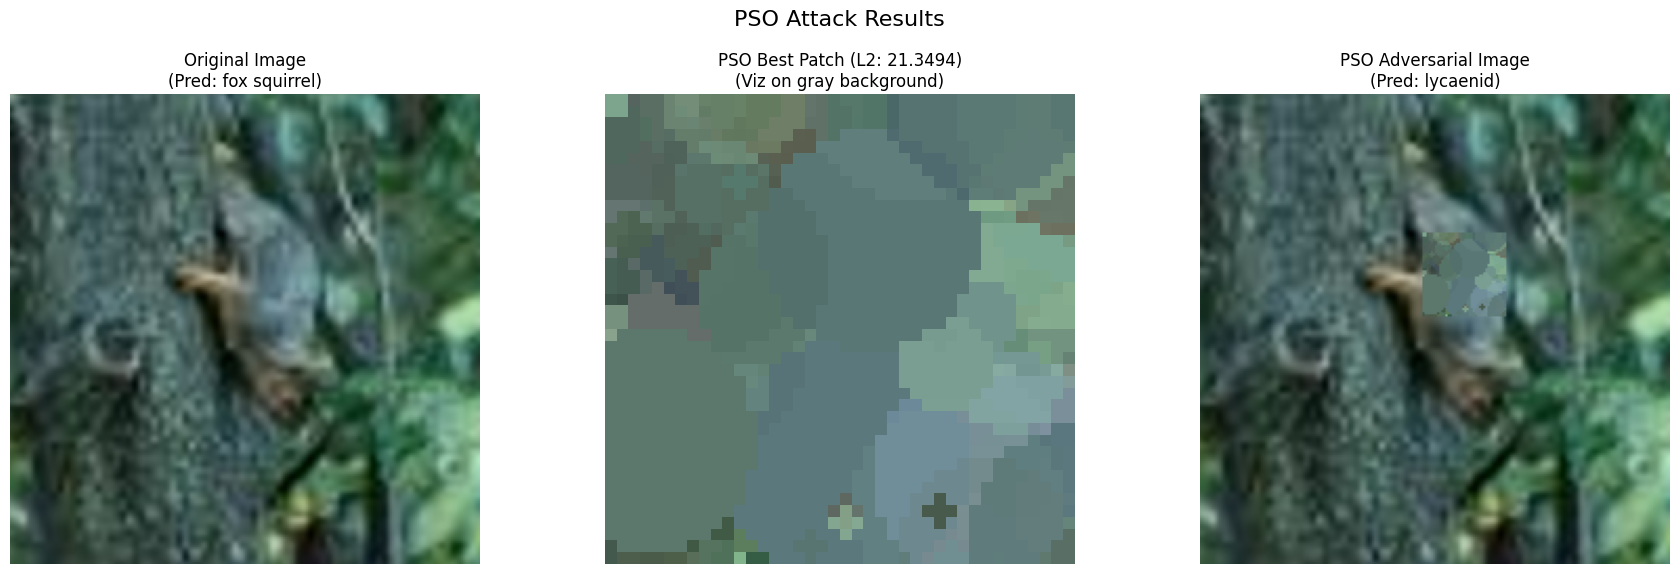

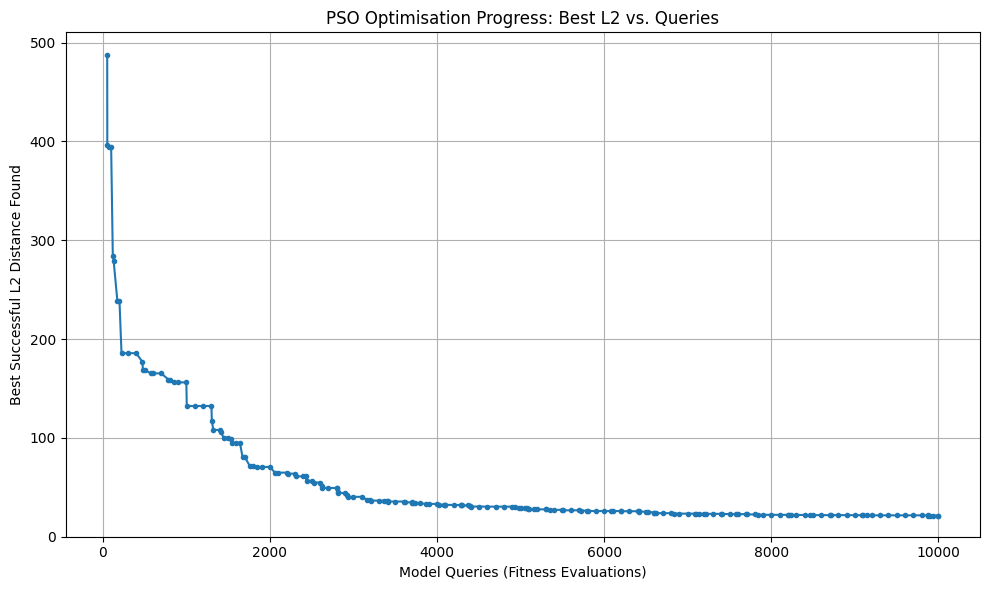


Total run time: 150.49s

 Optimisation finished!


In [ ]:
# Use the GPU if available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ImageNet normalisation stats
IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406], device=DEVICE).view(3, 1, 1)
IMAGENET_STD = torch.tensor([0.229, 0.224, 0.225], device=DEVICE).view(3, 1, 1)

# Suite of test images
test_image_list = ["https://github.com/EliSchwartz/imagenet-sample-images/blob/master/n01737021_water_snake.JPEG?raw=true",
                   "https://github.com/EliSchwartz/imagenet-sample-images/blob/master/n01773549_barn_spider.JPEG?raw=true",
                   "https://github.com/EliSchwartz/imagenet-sample-images/blob/master/n01740131_night_snake.JPEG?raw=true",
                   "https://github.com/EliSchwartz/imagenet-sample-images/blob/master/n02099267_flat-coated_retriever.JPEG?raw=true",
                   "https://github.com/EliSchwartz/imagenet-sample-images/blob/master/n02356798_fox_squirrel.JPEG?raw=true"]

# Alternatively, if loading from local files in session storage:
test_image_list = ["/content/test_image01.jpg",
                   "/content/test_image02.jpg",
                   "/content/test_image03.jpg",
                   "/content/test_image04.jpg",
                   "/content/test_image05.jpg"]

# Tunable hyperparameters
param_target_model = torchvision.models.resnet50
param_target_model_weights = ResNet50_Weights.IMAGENET1K_V1

# May use a relative file path or a URL
param_image_url = "https://github.com/EliSchwartz/imagenet-sample-images/blob/master/n02356798_fox_squirrel.JPEG?raw=true"
param_image_size = 224        # Input image size (must match model expectation)
param_palette_size = 16       # Number of colors in the optimised palette
param_patch_size = 40         # Size of the square adversarial patch (pixels)
param_num_circles = 100       # Number of circles composing the patch
param_pop_size = 100          # Number of particles in the swarm
param_num_iterations = 100    # Number of optimisation iterations
param_pso_w = 0.6             # Inertia weight
param_pso_c1 = 1.5            # Cognitive coefficient
param_pso_c2 = 1.5            # Social coefficient
param_pbest_tolerance = 0.5   # Attack success if target_logit - max_other_logit < tolerance (for pbest)
param_pso_g = 0.1             # Pulls circle colors towards palette colors (0 = disable)

# Print configuration
print("Configuration for this run:")
print(f"Current time: {time.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Device: {DEVICE}")
print(f"Image source: {param_image_url}")
print(f"Image size: {param_image_size}")
print(f"Palette size: {param_palette_size}")
print(f"Patch size: {param_patch_size}")
print(f"Num circles: {param_num_circles}")
print(f"PSO pop Size: {param_pop_size}")
print(f"PSO generations: {param_num_iterations}")
print(f"PSO params (w, c1, c2): ({param_pso_w}, {param_pso_c1}, {param_pso_c2})")
print(f"Constraint tolerance: {param_pbest_tolerance}")
print(f"Color gravity factor: {param_pso_g}")
print("------------------------------------")


# Execute the main function
if __name__ == "__main__":

    print("Beginning optimisation...")
    sucessful, final_l2 = run(image_url=param_image_url,
            target_model_factory=param_target_model,
            target_model_weights=param_target_model_weights,
            img_size=param_image_size,
            palette_size=param_palette_size,
            patch_size=param_patch_size,
            num_circles=param_num_circles,
            pso_population_size=param_pop_size,
            pso_generations=param_num_iterations,
            pso_w=param_pso_w,
            pso_c1=param_pso_c1,
            pso_c2=param_pso_c2,
            constraint_tolerance=param_pbest_tolerance,
            gravity_factor=param_pso_g,
            device=DEVICE)

print("\n Optimisation finished!")

## Appendix A - Hyperparameter Tuning

The following code cell demonstrates the process used for tuning hyperparameters. It iterates through a list of values for the target hyperparameter (`hp_vals`), runs a specified number of trials (`k`) for each value, calculates the average L2 distance for successful runs, and plots the results.

Adjust `hp_key`, `hp_vals`, and `k` to test different parameters.

Tuning 'pso_w' with values: [0.3, 0.6, 0.9]
Running 1 iterations for each value.
 Testing pso_w=0.3:
   Run 1/1...
Original prediction: fox squirrel (335) at 0.9549 conf.
K-Means converged after 24 iterations.
PSO init: pop=50, gens=50, target='fox squirrel'
  gen   1/50: Success   2/50 | Gen best L2: 342.4597 | Overall best L2: 342.4597 (Total queries: 50)
  gen   2/50: Success   4/50 | Gen best L2: 261.2910 | Overall best L2: 261.2910 (Total queries: 100)
  gen   3/50: Success   6/50 | Gen best L2: 184.4734 | Overall best L2: 184.4734 (Total queries: 150)
  gen   4/50: Success   7/50 | Gen best L2: 218.0659 | Overall best L2: 184.4734 (Total queries: 200)
  gen   5/50: Success  10/50 | Gen best L2: 245.2302 | Overall best L2: 184.4734 (Total queries: 250)
  gen   6/50: Success   7/50 | Gen best L2: 155.7258 | Overall best L2: 155.7258 (Total queries: 300)
  gen   7/50: Success  12/50 | Gen best L2: 148.7172 | Overall best L2: 148.7172 (Total queries: 350)
  gen   8/50: Success  15/50

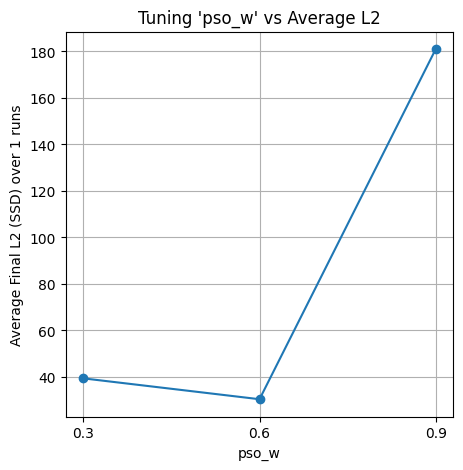

In [14]:
# Base config
cfg = {
    "image_url": "https://github.com/EliSchwartz/imagenet-sample-images/blob/master/n02356798_fox_squirrel.JPEG?raw=true",
    "target_model_factory": torchvision.models.resnet50,
    "target_model_weights": ResNet50_Weights.IMAGENET1K_V1,
    "img_size": 224,
    "palette_size": 16,
    "patch_size": 40,
    "num_circles": 100,
    "pso_population_size": 50,
    "pso_generations": 50,
    "pso_w": 0.6,
    "pso_c1": 1.5,
    "pso_c2": 1.5,
    "constraint_tolerance": 0.5,
    "gravity_factor": 0.1,
    "device": DEVICE
}

# Tuning setup
hp_key = "pso_w" # Param key from cfg to tune
hp_vals = [0.3, 0.6, 0.9] # List of values to test
k = 1 # For quick demonstration, increased for real testing

# Run and collect results
results = {}
print(f"Tuning '{hp_key}' with values: {hp_vals}")
print(f"Running {k} iterations for each value.")

for val in hp_vals:
    print(f" Testing {hp_key}={val}:")
    run_cfg = cfg.copy()
    run_cfg[hp_key] = val

    l2_scores_for_val = []

    for i in range(k):
        print(f"   Run {i+1}/{k}...", end="")
        success, final_l2 = run(**run_cfg, plot=False)

        if success:
            print(f" Success! L2={final_l2:.4f}")
            l2_scores_for_val.append(final_l2)
        else:
            print("Failed.")

    # Calculate average l2
    if l2_scores_for_val:
        average_l2 = np.mean(l2_scores_for_val)
        num_success = len(l2_scores_for_val)
        print(f"Avg l2 for {hp_key}={val}: {average_l2:.4f} ({num_success}/{k} successful runs)")
        results[val] = average_l2
    else:
        print(f"No successful runs for {hp_key}={val} out of {k} attempts.")

# Plot results
if results:
    sorted_vals = sorted(results.keys())
    sorted_average_l2s = [results[v] for v in sorted_vals]

    #np.save(f"{hp_key}_y.npy", np.array(sorted_average_l2s))
    #np.save(f"{hp_key}_x.npy", np.array(sorted_vals))

    plt.figure(figsize=(5, 5))
    plt.plot(sorted_vals, sorted_average_l2s, marker="o", linestyle="-")
    plt.xlabel(hp_key)
    plt.ylabel(f"Average Final L2 (SSD) over {k} runs")
    plt.title(f"Tuning '{hp_key}' vs Average L2")
    plt.grid(True)
    plt.xticks(hp_vals)
    plt.show()
else:
    print("No successful runs were recorded across all values and iterations to plot.")

## Appendix B - Random Search Baseline

The following cell implements the Random Search (RS) baseline comparison. It generates random candidate solutions within the defined parameter space for a fixed number of total evaluations (matching the main algorithm's budget) and evaluates them.

The number of evaluations (`total_random_queries`) is set based on parameters defined earlier in the notebook.


Starting random search comparison...
Random Search: Original Prediction: fox squirrel (335)
Random search best: l2 = 13.7499, prediction: birdhouse (448)


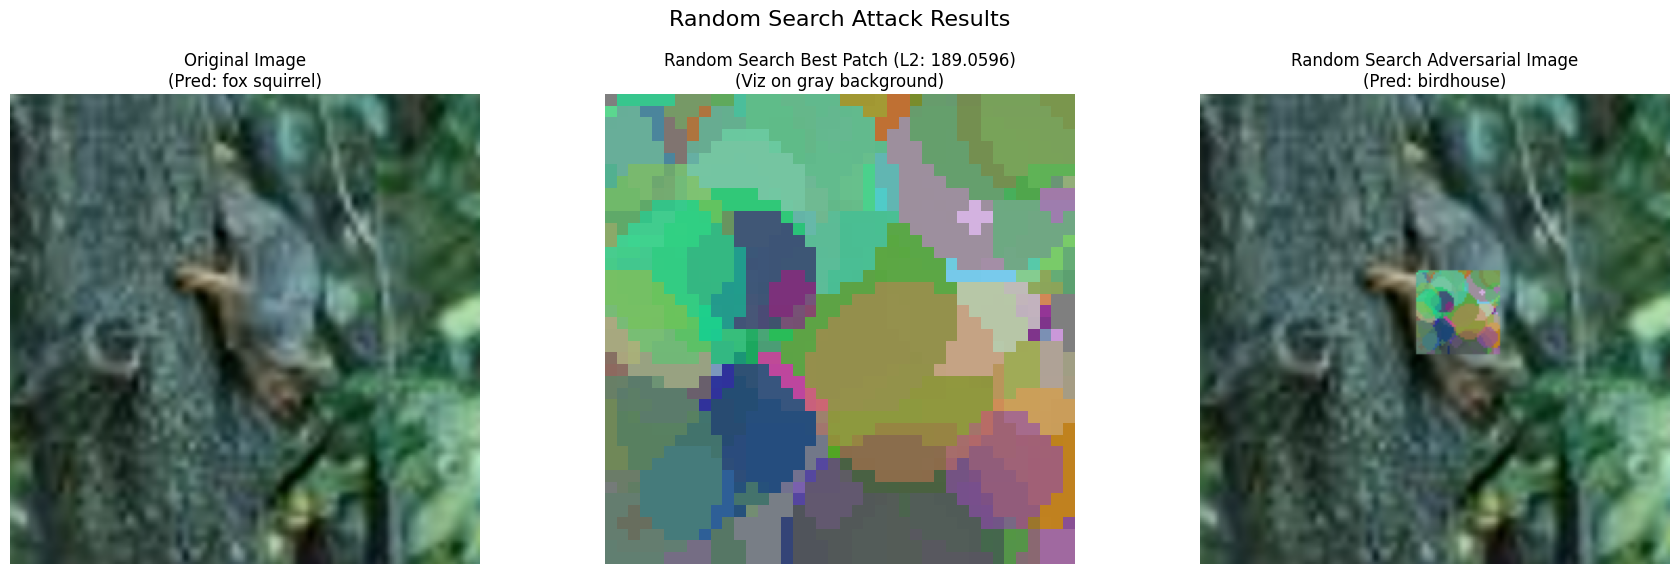

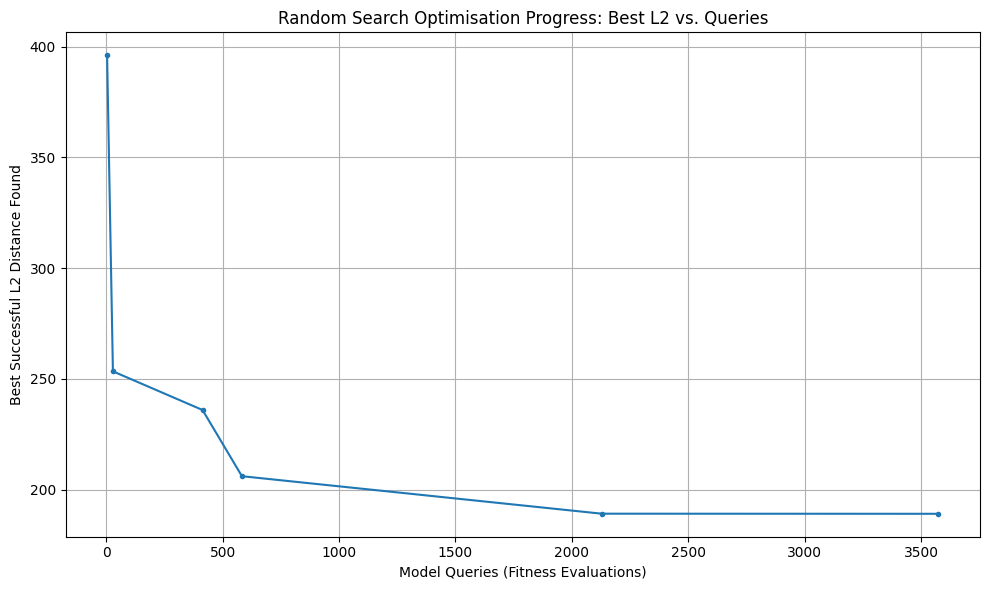

In [15]:
print("\nStarting random search comparison...")

# Re-process the image and set up the target model
original_full_pil, cropped_pil_image, original_tensor_unnormalised = preprocess_image(param_image_url, param_image_size)
original_tensor_normalised = normalise_tensor(original_tensor_unnormalised)
target_model = param_target_model(weights=param_target_model_weights).eval().to(DEVICE)

# Evaluate
with torch.no_grad():
    outputs = target_model(original_tensor_normalised)

# Extract labels
probs = torch.softmax(outputs, dim=1)
label_idx = torch.argmax(probs, dim=1).item()
imagenet_labels = param_target_model_weights.meta["categories"]
original_label_str = imagenet_labels[label_idx]
print(f"Random Search: Original Prediction: {original_label_str} ({label_idx})")

# Compute parameter dimension and bounds (condensed from main function)
n_params_per_circle = 7
n_patch_loc_params = 2
particle_dim = n_patch_loc_params + param_num_circles * n_params_per_circle
loc_bounds = [(0, param_image_size - param_patch_size)] * n_patch_loc_params
circle_bounds_spec = [(0, 1)] * n_params_per_circle
circle_bounds_spec[2], circle_bounds_spec[6] = (0.01, 0.5), (0.05, 1.0)
all_circle_bounds_list = []
for _ in range(param_num_circles):
    all_circle_bounds_list.extend(circle_bounds_spec)
param_bounds_min_np = np.array([b[0] for b in loc_bounds] + [b[0] for b in all_circle_bounds_list], dtype=np.float32)
param_bounds_max_np = np.array([b[1] for b in loc_bounds] + [b[1] for b in all_circle_bounds_list], dtype=np.float32)
param_bounds_min = torch.tensor(param_bounds_min_np, dtype=torch.float32, device=DEVICE)
param_bounds_max = torch.tensor(param_bounds_max_np, dtype=torch.float32, device=DEVICE)

# Set total number of fitness evaluations equal (pop_size x generations)
total_random_queries = param_pop_size * param_num_iterations
best_random_l2 = float("inf")
best_random_position = None
random_query_history = []
best_l2_history = []

# Random Search Loop
for query in range(1, total_random_queries + 1):
    pos = torch.rand(particle_dim, device=DEVICE) * (param_bounds_max - param_bounds_min) + param_bounds_min
    fitness, misclassified, l2, _ = evaluate_fitness(pos, original_tensor_unnormalised, label_idx,
                                                     target_model, param_patch_size, param_num_circles, param_pbest_tolerance)
    if misclassified and l2 < best_random_l2:
        best_random_l2 = l2
        best_random_position = pos.clone()
        random_query_history.append(query)
        best_l2_history.append(best_random_l2)

if best_random_position is not None:
    # Re-evaluate the best candidate
    final_fitness, final_misclassified, final_l2, final_patched = evaluate_fitness(
        best_random_position, original_tensor_unnormalised, label_idx, target_model,
        param_patch_size, param_num_circles, param_pbest_tolerance
    )
    final_normalised = normalise_tensor(final_patched)
    with torch.no_grad():
        final_outputs = target_model(final_normalised)
    final_probs = torch.softmax(final_outputs, dim=1)
    final_label_idx = torch.argmax(final_probs, dim=1).item()
    final_predicted_label_str = imagenet_labels[final_label_idx]
    print(f"Random search best: l2 = {np.sqrt(best_random_l2):.4f}, prediction: {final_predicted_label_str} ({final_label_idx})")

    # Generate patch visualisation and the adversarial image
    best_patch = generate_patch(best_random_position, param_patch_size, param_num_circles)
    best_patch_rgb, best_patch_alpha = generate_patch_tensors(best_patch)
    gray_bg = torch.ones_like(best_patch_rgb) * 0.5
    vis_patch = T.ToPILImage()(torch.clamp(gray_bg * (1 - best_patch_alpha) + best_patch_rgb * best_patch_alpha, 0, 1).cpu())
    loc_params = best_random_position[:n_patch_loc_params].cpu().numpy()
    patch_x = int(np.clip(loc_params[0].round(), 0, param_image_size - param_patch_size))
    patch_y = int(np.clip(loc_params[1].round(), 0, param_image_size - param_patch_size))
    adv_img = cropped_pil_image.copy()
    adv_img.paste(best_patch, (patch_x, patch_y), mask=best_patch.split()[3])

    # Plot the results and convergence
    plot_results_figure(cropped_pil_image, vis_patch, adv_img,
                        original_label_str, final_predicted_label_str, best_random_l2, title_suffix="Random Search")
    plot_convergence(random_query_history, best_l2_history, algorithm_name="Random Search")
    np.save("random_x.npy", random_query_history)
    np.save("random_y.npy", best_l2_history)
else:
    print("No successful patch found.")


## Appendix C - Stochastic Hillclimber baseline

The following cell implements the Stochastic Hill Climber (SHC) baseline comparison. It starts from a random solution and iteratively explores neighbours generated by adding Gaussian noise, accepting improving solutions that cause misclassification, for a fixed number of total evaluations.

The number of evaluations (`total_hc_queries`) is set based on parameters defined earlier in the notebook.


Starting stochastic hillclimber comparison...
Stochastic Hillclimber: Original prediction: fox squirrel (335)
Stochastic Hillclimber best: l2 = 9.2798, prediction: pinwheel (723)


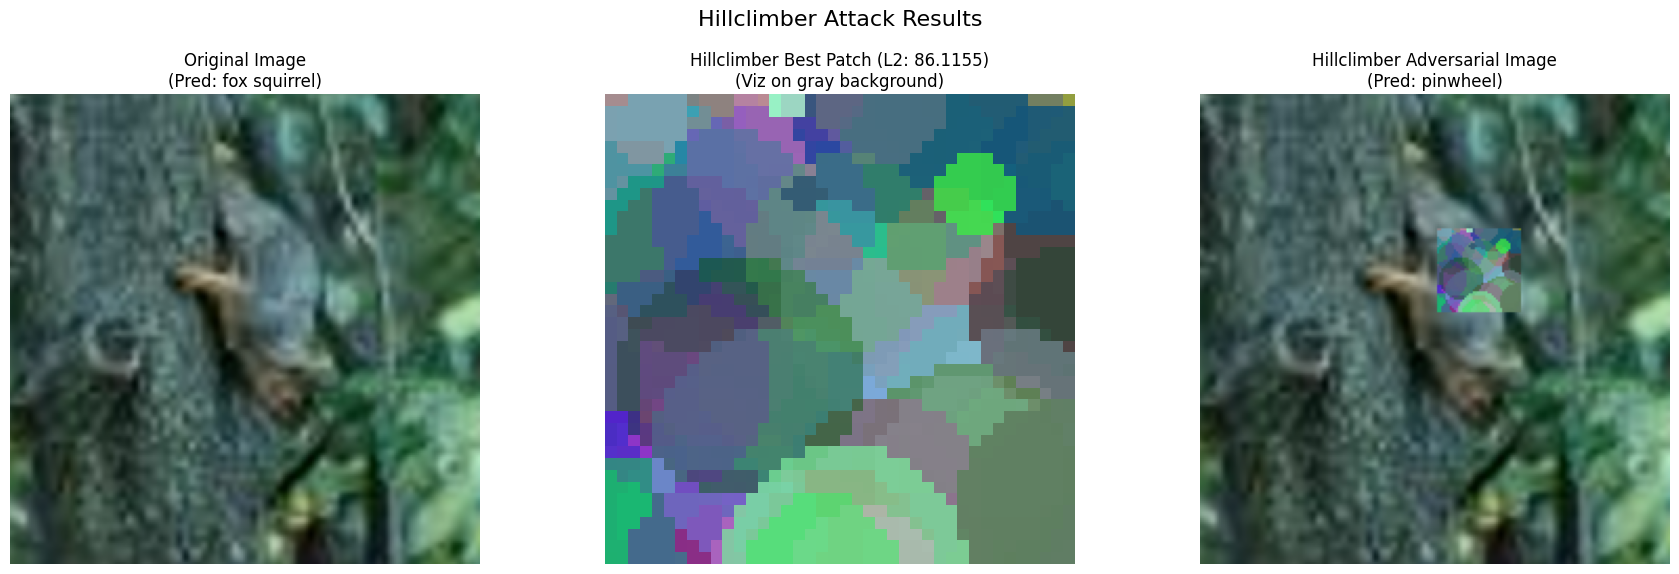

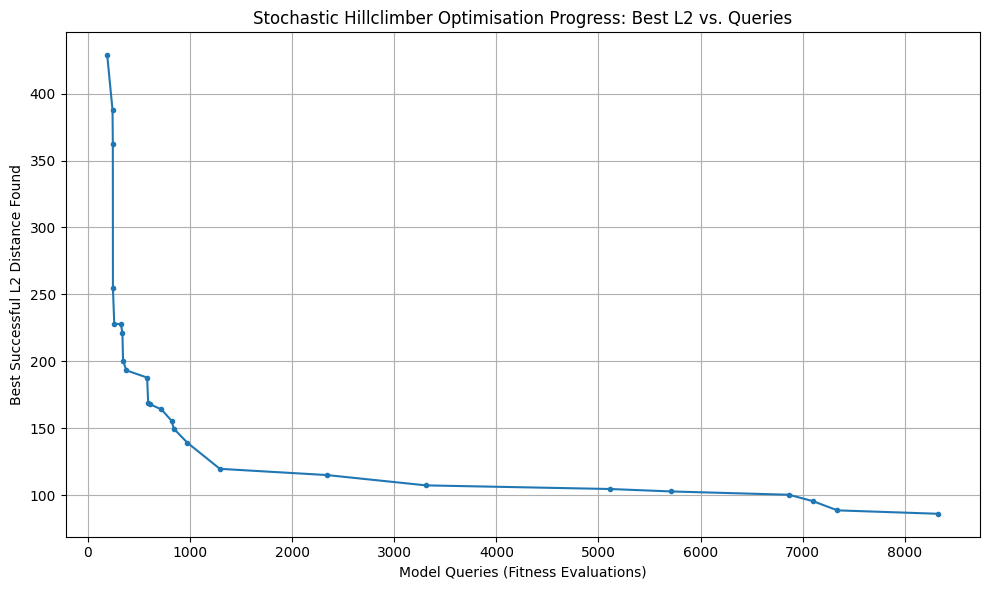

In [16]:
print("\nStarting stochastic hillclimber comparison...")

# Image and target model
original_full_pil, cropped_pil_image, original_tensor_unnormalized = preprocess_image(param_image_url, param_image_size)
original_tensor_normalised = normalise_tensor(original_tensor_unnormalized)
target_model = param_target_model(weights=param_target_model_weights).eval().to(DEVICE)
with torch.no_grad():
    outputs = target_model(original_tensor_normalised)
probs = torch.softmax(outputs, dim=1)
label_idx = torch.argmax(probs, dim=1).item()
imagenet_labels = param_target_model_weights.meta["categories"]
original_label_str = imagenet_labels[label_idx]
print(f"Stochastic Hillclimber: Original prediction: {original_label_str} ({label_idx})")

# Parameter dimensions & bounds
n_params_per_circle = 7
n_patch_loc_params = 2
particle_dim = n_patch_loc_params + param_num_circles * n_params_per_circle
loc_bounds = [(0, param_image_size - param_patch_size)] * n_patch_loc_params
circle_bounds_spec = [(0, 1)] * n_params_per_circle
circle_bounds_spec[2], circle_bounds_spec[6] = (0.01, 0.5), (0.05, 1.0)
all_circle_bounds_list = []
for _ in range(param_num_circles):
    all_circle_bounds_list.extend(circle_bounds_spec)
param_bounds_min_np = np.array([b[0] for b in loc_bounds] + [b[0] for b in all_circle_bounds_list], dtype=np.float32)
param_bounds_max_np = np.array([b[1] for b in loc_bounds] + [b[1] for b in all_circle_bounds_list], dtype=np.float32)
param_bounds_min = torch.tensor(param_bounds_min_np, dtype=torch.float32, device=DEVICE)
param_bounds_max = torch.tensor(param_bounds_max_np, dtype=torch.float32, device=DEVICE)

# Total number of fitness evaluations for hillclimbing
total_hc_queries = param_pop_size * param_num_iterations

# Initialize with a random candidate within bounds
current_candidate = torch.rand(particle_dim, device=DEVICE) * (param_bounds_max - param_bounds_min) + param_bounds_min
current_fitness, current_misclassified, current_l2, _ = evaluate_fitness(
    current_candidate, original_tensor_unnormalized, label_idx,
    target_model, param_patch_size, param_num_circles, param_pbest_tolerance
)

hc_query_history = []  # Records queries at which improvement occurred
hc_best_history = []   # Records best fitness values

# Update only if candidate misclassifies and improves fitness.
for query in range(1, total_hc_queries + 1):
    # Generate a neighbor by adding gaussian noise
    noise = torch.randn(particle_dim, device=DEVICE) * (0.05 * (param_bounds_max - param_bounds_min))
    neighbor = torch.clamp(current_candidate + noise, param_bounds_min, param_bounds_max)

    f_neighbor, mis_neighbor, l2_neighbor, _ = evaluate_fitness(
        neighbor, original_tensor_unnormalized, label_idx,
        target_model, param_patch_size, param_num_circles, param_pbest_tolerance
    )

    if mis_neighbor and f_neighbor < current_fitness:
        current_candidate = neighbor.clone()
        current_fitness = f_neighbor
        current_l2 = l2_neighbor
        hc_query_history.append(query)
        hc_best_history.append(current_fitness)

# Final evaluation and visualisation
if current_fitness < float("inf"):
    final_fitness, final_misclassified, final_l2, final_patched = evaluate_fitness(
        current_candidate, original_tensor_unnormalised, label_idx, target_model,
        param_patch_size, param_num_circles, param_pbest_tolerance
    )
    final_normalised = normalise_tensor(final_patched)
    with torch.no_grad():
        final_outputs = target_model(final_normalised)
    final_probs = torch.softmax(final_outputs, dim=1)
    final_label_idx = torch.argmax(final_probs, dim=1).item()
    final_predicted_label_str = imagenet_labels[final_label_idx]
    print(f"Stochastic Hillclimber best: l2 = {np.sqrt(current_fitness):.4f}, prediction: {final_predicted_label_str} ({final_label_idx})")

    # Generate patch and adversarial image visuals
    best_patch = generate_patch(current_candidate, param_patch_size, param_num_circles)
    best_patch_rgb, best_patch_alpha = generate_patch_tensors(best_patch)
    gray_bg = torch.ones_like(best_patch_rgb) * 0.5
    vis_patch = T.ToPILImage()(torch.clamp(gray_bg * (1 - best_patch_alpha) + best_patch_rgb * best_patch_alpha, 0, 1).cpu())
    loc_params = current_candidate[:n_patch_loc_params].cpu().numpy()
    patch_x = int(np.clip(loc_params[0].round(), 0, param_image_size - param_patch_size))
    patch_y = int(np.clip(loc_params[1].round(), 0, param_image_size - param_patch_size))
    adv_img = cropped_pil_image.copy()
    adv_img.paste(best_patch, (patch_x, patch_y), mask=best_patch.split()[3])

    plot_results_figure(cropped_pil_image, vis_patch, adv_img,
                        original_label_str, final_predicted_label_str, current_fitness, title_suffix="Hillclimber")
    plot_convergence(hc_query_history, hc_best_history, algorithm_name="Stochastic Hillclimber")
else:
    print("No successful patch found.")


## Appendix D - Averaged Convergence Plot

The following cell generates the comparative convergence plot (Figure 2 in the report). It loads the saved query count and L2 distance history from .npy files from multiple runs for each algorithm, calculates the average best L2 found over time, and plots these averaged curves.

To reproduce, ensure the file paths at the start of the cell point to the correct .npy files saved from previous experimental runs.

In [ ]:

# Requires that runs have been saved previously
mine_x_files = [r"/mine_x.npy", r"/mine_x.npy", r"/mine_x.npy"]
mine_y_files = [r"/mine_y.npy", r"/mine_y_2.npy", r"/mine_y_3.npy"]
orig_x_files = [r"/original_x.npy", r"/original_x.npy", r"/original_x.npy"]
orig_y_files = [r"/original_y.npy", r"/original_y_2.npy", r"/original_y_3.npy"]
rand_x_files = [r"/random_x.npy", r"/random_x_2.npy", r"/random_x_3.npy"]
rand_y_files = [r"/random_y.npy", r"/random_y_2.npy", r"/random_y_3.npy"]

# Ensure all files exist
all_files = mine_x_files + mine_y_files + orig_x_files + orig_y_files + rand_x_files + rand_y_files
missing_files = [f for f in all_files if not os.path.exists(f)]

if missing_files:
    print("This cell requires that runs have been saved previously.")
    print("Please ensure the files exist before running.")
    DATA_FILES_OK = False
else:
    DATA_FILES_OK = True
    print("All required data files found.")

# Function definitions
def load_data(x_paths, y_paths):
    """
    Loads pairs of X (queries) and Y (L2) data from .npy files.
    """
    xs, ys = [], []

    for xf, yf in zip(x_paths, y_paths):
        xs.append(np.load(xf))
        ys.append(np.load(yf))
    return xs, ys

def get_avg_curve(xs, ys):
    """
    Processes multiple runs, interpolates to common queries, averages l2.
    """
    all_q, proc_runs = set(), []

    # Process each run to get best l2 so far vs query points
    # Condensed from plot convergence function in cell 7
    for xr, yr in zip(xs, ys):
        if xr.size == 0 or yr.size == 0: continue
        # Process points in increasing order
        s_idx = np.argsort(xr); x, y = xr[s_idx], yr[s_idx]
        # Init
        best_l2, run_q, run_l2, added = float("inf"), [], [], set()

        for q, l2 in zip(x, y):
            cur_best = run_l2[-1] if run_l2 else float("inf")
            if q in added and l2 >= cur_best: continue
            if np.isfinite(l2): best_l2 = min(best_l2, l2)
            if q not in added:
                # If this is the first time seeing query q in this run
                run_q.append(q); run_l2.append(best_l2); added.add(q)
            elif np.isfinite(l2) and l2 < cur_best:
                 run_l2[run_q.index(q)] = best_l2 # Update if better finite L2 for existing q
        pq, pl2 = np.array(run_q), np.array(run_l2)
        proc_runs.append((pq, pl2))
        all_q.update(pq)

    if not all_q: return np.array([]), np.array([]) # No data points found

    # Create common query axis and interpolate data
    common_q = np.unique(np.sort(list(all_q)))
    interp_curves = np.full((len(proc_runs), len(common_q)), float("inf"))

    for i, (rq, rl2) in enumerate(proc_runs):
        if rq.size == 0: continue
        idx = np.searchsorted(rq, common_q, side="right") # Find indices for interpolation

        for j, cq_val in enumerate(common_q):
             # Use the l2 value from the latest query <= current common query point
            if idx[j] > 0: interp_curves[i, j] = rl2[idx[j] - 1]
    avg_l2 = np.full(len(common_q), float("inf"))

    for j in range(len(common_q)): # Average over runs for each common query point
        finite = interp_curves[:, j][np.isfinite(interp_curves[:, j])]
        if len(finite) > 0: avg_l2[j] = np.mean(finite)
    return common_q, avg_l2

# Generate the plot
if DATA_FILES_OK:
    # Load data
    mine_x, mine_y = load_data(mine_x_files, mine_y_files)
    orig_x, orig_y = load_data(orig_x_files, orig_y_files)
    rand_x, rand_y = load_data(rand_x_files, rand_y_files)

    # Process data to get average curves
    m_cq, m_a = get_avg_curve(mine_x, mine_y)
    o_cq, o_a = get_avg_curve(orig_x, orig_y)
    r_cq, r_a = get_avg_curve(rand_x, rand_y)

    # Plot the processed data
    plt.figure(figsize=(7, 4))
    m_mask, o_mask, r_mask = np.isfinite(m_a), np.isfinite(o_a), np.isfinite(r_a)
    plotted = False
    if m_cq.size > 0 and np.any(m_mask): # Only plot if data exists and is finite
        plt.plot(m_cq[m_mask], m_a[m_mask], label=f"Proposed Method (Avg. {len(mine_x)})", linestyle="-")
        plotted = True
    if o_cq.size > 0 and np.any(o_mask):
        plt.plot(o_cq[o_mask], o_a[o_mask], label=f"CamoPatch (Avg. {len(orig_x)})", linestyle="--")
        plotted = True
    if r_cq.size > 0 and np.any(r_mask):
        plt.plot(r_cq[r_mask], r_a[r_mask], label=f"Random Baseline (Avg. {len(rand_x)})", linestyle=":")
        plotted = True

    if plotted: # Add labels/legend only if something was actually plotted
        plt.xlabel("Model Queries (Fitness Evaluations)")
        plt.ylabel("Average Best L2 Distance (SSD)")
        plt.title(f"L2 Convergence Comparison (Avg. of {len(orig_x)} runs)")
        plt.grid(True, alpha=0.5)
        plt.legend()
        plt.tight_layout()
        plt.show()

This cell requires that runs have been saved previously.
Please ensure the files exist before running.


## Appendix E - Patch Placement Plots

The following cell generates the patch placement comparison plots (Figure 5 in the report). It loads specified images and plots the final patch center coordinates manually entered from experimental runs for the compared algorithms.

To reproduce, ensure the image URLs and coordinate lists at the start of the cell are set correctly.

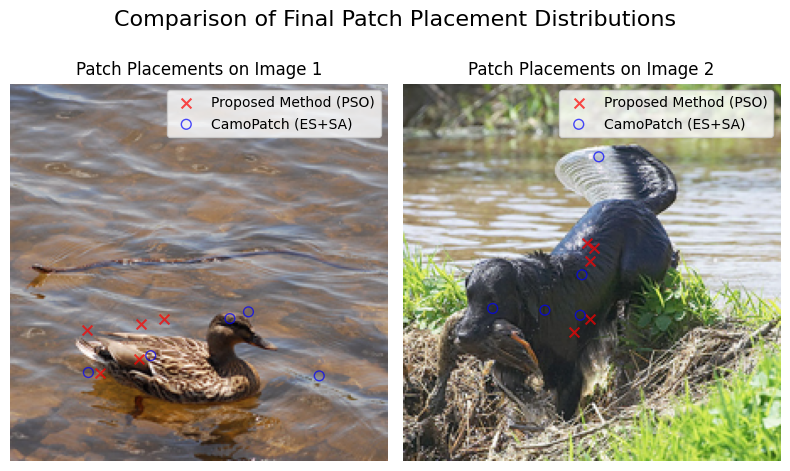

In [18]:
# Image URLs
img1_url = "https://github.com/EliSchwartz/imagenet-sample-images/blob/master/n01737021_water_snake.JPEG?raw=true"
img2_url = "https://github.com/EliSchwartz/imagenet-sample-images/blob/master/n02099267_flat-coated_retriever.JPEG?raw=true"

# Patch coordinates can be obtained from the printouts of the main cell
# Coordinates from the original CamoPatch were obtained manually
# For the purposes of the paper 5 runs were conducted for each image

# Coordinates for image 1
m1_x1 = [77, 45, 91, 53, 76]
m1_y1 = [142, 146, 139, 171, 163]
m2_x1 = [83, 130, 141, 183, 46]
m2_y1 = [161, 139, 135, 173, 171]

# Coordinates for image 2
m1_x2 = [101, 109, 111, 111, 113]
m1_y2 = [147, 94, 139, 105, 97]
m2_x2 = [53, 105, 106, 116, 84]
m2_y2 = [133, 137, 113, 43, 134]

method1_label = "Proposed Method (PSO)"
method2_label = "CamoPatch (ES+SA)"
marker_size = 50
marker_alpha = 0.7
subplot1_title = "Patch Placements on Image 1"
subplot2_title = "Patch Placements on Image 2"
figure_title = "Comparison of Final Patch Placement Distributions"

# Load and preprocess images just as they were during optimisation
img1_cropped, img2_cropped = None, None

_, img1_cropped, _ = preprocess_image(img1_url, target_size=224)
_, img2_cropped, _ = preprocess_image(img2_url, target_size=224)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 5))

# Image 1
ax1.imshow(img1_cropped)
ax1.scatter(m1_x1, m1_y1, marker="x", color="red", s=marker_size, alpha=marker_alpha, label=method1_label)
ax1.scatter(m2_x1, m2_y1, marker="o", edgecolors="blue", facecolors="none", s=marker_size, alpha=marker_alpha, label=method2_label)
ax1.set_title(subplot1_title)
ax1.axis("off")
ax1.legend()

# Image 2
ax2.imshow(img2_cropped)
ax2.scatter(m1_x2, m1_y2, marker="x", color="red", s=marker_size, alpha=marker_alpha, label=method1_label)
ax2.scatter(m2_x2, m2_y2, marker="o", edgecolors="blue", facecolors="none", s=marker_size, alpha=marker_alpha, label=method2_label)
ax2.set_title(subplot2_title)
ax2.axis("off")
ax2.legend()

fig.suptitle(figure_title, fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

## Appendix F - Statistical Testing

The following cell processes the manually entered experimental results data  for all compared algorithms. It calculates summary statistics (ASR, Mean/Median/Std Dev L2), performs Wilcoxon signed-rank tests to compare L2 performance between methods, and generates the final summary table (Table 1 in the report).

To reproduce, ensure the data lists at the start of the cell contain the correct results from experimental runs.

In [19]:
import numpy as np
from scipy import stats
import pandas as pd

# Data compiled here from the main cell, Appendices B and C, and CamoPatch
# Assumes N runs on the same set of distinct problem instances
pso_s =  [False, True, True, True, True, True, False, True, True, True]
pso_l2 = [float("inf"), 7.97, 4.80, 4.20, 6.1, 8.53, float("inf"), 2.17, 3.67, 4.65]

camo_s = [True, True, True, True, True, True, True, True, True, True]
camo_l2 = [6.89, 9.67, 4.66, 3.70, 7.06, 5.44, 3.52, 2.86, 5.39, 5.61]

rs_s =   [True, True, True, True, True, True, True, True, True, True]
rs_l2 =  [20.34, 16.87, 12.73, 12.38, 19.21, 19.20, 20.34, 20.14, 13.99, 13.06]

shc_s =  [True, True, True, True, True, True, True, True, True, False]
shc_l2 = [15.34, 13.77, 7.22, 8.18, 14.31, 16.69, 13.09, 8.72, 10.26, float("inf")]

def calculate_stats(s_flags, l2_vals):
    """
    Calculate ASR, Mean L2, Median L2, Std L2 for successful runs.
    """
    n = len(s_flags)
    s_count = sum(s for s in s_flags if s)

    asr = s_count / n if n > 0 else np.nan

    # Get L2 values only from successful runs (finite L2)
    s_l2s = [l2 for s, l2 in zip(s_flags, l2_vals) if s and np.isfinite(l2)]

    # Calculate mean, median and std dev
    if not s_l2s:
        m_l2, med_l2, sd_l2 = np.nan, np.nan, np.nan # Set all to nan if no successes
    else:
        m_l2 = np.mean(s_l2s)
        med_l2 = np.median(s_l2s)
        sd_l2 = np.std(s_l2s, ddof=1) if len(s_l2s) > 1 else 0.0 # Sample std

    # Return dictionary
    return {"ASR": asr, "Mean l2": m_l2, "Median l2": med_l2, "Std l2": sd_l2}

def run_test(d1, s1, d2, s2, name1="A1", name2="A2", alt="two-sided"):
    """
    Compare l2 from paired successful runs using Wilcoxon.
    """
    # Include only pairs where both algorithms succeeded
    # (Messy I know)
    p1 = [v1 for v1, v2, ok1, ok2 in zip(d1, d2, s1, s2) if ok1 and ok2 and np.isfinite(v1) and np.isfinite(v2)]
    p2 = [v2 for v1, v2, ok1, ok2 in zip(d1, d2, s1, s2) if ok1 and ok2 and np.isfinite(v1) and np.isfinite(v2)]

    if len(p1) < 5 : # Check for minimum pairs for validity
        print(f"Test {name1} vs {name2}: skip (N={len(p1)} < 5)")
        return

    # Perform test
    stat, p = stats.wilcoxon(np.array(p1) - np.array(p2), alternative=alt, zero_method="wilcox")
    print(f"Test {name1} vs {name2} (L2, N={len(p1)}, alt='{alt}'): p={p:.4f}")

# Calculate stats
pso_st = calculate_stats(pso_s, pso_l2)
camo_st = calculate_stats(camo_s, camo_l2)
rs_st = calculate_stats(rs_s, rs_l2)
shc_st = calculate_stats(shc_s, shc_l2)

# Run tests
print("\nWilcoxon signed-rank test")
run_test(pso_l2, pso_s, camo_l2, camo_s, "PSO", "Camo")
run_test(pso_l2, pso_s, rs_l2, rs_s, "PSO", "RS", alt="less")
run_test(pso_l2, pso_s, shc_l2, shc_s, "PSO", "SHC", alt="less")

# Generate and display table
print("\nResults Summary")
tbl_data = {"PSO": pso_st, "CamoPatch": camo_st, "RS": rs_st, "SHC": shc_st}
df = pd.DataFrame(tbl_data).T

# Select and format columns for display
display_cols = ["ASR", "Mean l2", "Median l2", "Std l2"]
df_display = df[display_cols]
df_display["ASR"] = df_display["ASR"].map("{:.1%}".format)
df_display[["Mean L2", "Median L2", "Std L2"]] = df_display[["Mean l2", "Median l2", "Std l2"]].applymap("{:.3f}".format)

display(df_display)


Wilcoxon signed-rank test
Test PSO vs Camo (L2, N=8, alt='two-sided'): p=0.3672
Test PSO vs RS (L2, N=8, alt='less'): p=0.0039
Test PSO vs SHC (L2, N=7, alt='less'): p=0.0078

Results Summary


<ipython-input-19-844ba1eddf5e>:80: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_display[["Mean L2", "Median L2", "Std L2"]] = df_display[["Mean l2", "Median l2", "Std l2"]].applymap("{:.3f}".format)


,ASR,Mean l2,Median l2,Std l2,Mean L2,Median L2,Std L2
PSO,80.0%,5.261250,4.725,2.155594,5.261,4.725,2.156
CamoPatch,100.0%,5.480000,5.415,2.016983,5.480,5.415,2.017
RS,100.0%,16.826000,18.035,3.428152,16.826,18.035,3.428
SHC,90.0%,11.953333,13.090,3.428119,11.953,13.090,3.428
